In [1]:
import os
import string
from datetime import datetime
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
def timediff(t1,t2):
    #t1=(t1 + '000')
    #t2=(t2 + '000')
    day1=datetime.strptime(t1, "%d:%m:%Y:%H:%M:%S:%f")
    day2=datetime.strptime(t2, "%d:%m:%Y:%H:%M:%S:%f")
    sec = (day2-day1).total_seconds()
    return(sec)

In [3]:
def extract_keylog_features(path):
    lines = [line.rstrip('\t\n') for line in open(path)]
    f_list = [event.split('\t') for event in lines]
    #lines2 = [line.rstrip('\t\n') for line in open('1.txt')]
    #f_list2 = [event.split('\t') for event in lines2]
    alp = list(string.ascii_lowercase)
    alp2 = list(map(''.join,itertools.combinations(string.ascii_lowercase,2)))

    KeyUps = [x for x in f_list if 'KeyUp' in x]
    KeyDowns = [x for x in f_list if 'KeyDown' in x]

    tups =  [item[2] for item in KeyUps]# if item[1] in alp]
    tdowns =  [item1[2] for item1 in KeyDowns]# if item1[1] in alp]
    try:
        letterup =  [item[1].upper() for item in KeyUps]# if item[1] in alp]
    except: 
        pass

    try:
        letterdown = [item1[1].upper() for item1 in KeyDowns]# if item1[1] in alp]
    except:
        pass

    features = []
    for i in range(0,len(tups)-1):
        t = i

        t1 = tdowns[i] #timestamp of downpress

        if letterup[t] != letterdown[i]: #Simultaneous press
            j = i

            if i == len(tups)-1:
                j = 0
            while j<len(tups)-1 and letterdown[i]!= letterup[j] and i!=len(tups)-1: #skip inbetween to go to the release key
                j = j+1

            tj = tups[j]
            k = i

            if i == 0:
                k = len(tups)-1
            while k>=1 and letterdown[i]!= letterup[k] and i!=0: # repeat same key
                k = k-1

            tk = tups[k]


            if timediff(t1,tk)>0 and timediff(t1,tj)>0 :
                if abs(j-i)<abs(i-k):
                    t = j
                else:
                    t = k

            elif timediff(t1,tk)<0 :
                t = j
            else:
                t = k

        t2 = tups[t]        # release time stamp



        if i!=len(tups)-1:

            t3 = tdowns[i+1]  # Next key time stamp
            latency = timediff(t1,t3)

            lat = letterdown[i]+letterdown[i+1],latency
            features.append(lat)

        hold_time = timediff(t1,t2)
        hold = letterdown[i],hold_time
        features.append(hold)
        
    return features

In [4]:
Roll_nos = ['17EC32005', '17EC34003', '17EC35023', '17EC35036', '18EC10025', '18EC35010', '18EC35021', '18EC35045', '18EC3AI19']
num_roll_nos = len(Roll_nos)
os.chdir("/home/digvijay-pc/Desktop/MIES/OneDrive_2021-11-08/Term Project/")

data_features = []
data_tags = []
unique_features = set([])

for r in range(num_roll_nos):
    for subdir,dirs,file in os.walk(os.path.join('/home/digvijay-pc/Desktop/MIES/OneDrive_2021-11-08/Term Project/Continuous Data Rearranged',Roll_nos[r])):
        for directory in dirs:
#             print(subdir,directory)
            features = extract_keylog_features(os.path.join('/home/digvijay-pc/Desktop/MIES/OneDrive_2021-11-08/Term Project/Continuous Data Rearranged',Roll_nos[r],directory,'KeyLog.txt'))
            data_features.append(features)
            data_tags.append(r)
            
            unique_features = unique_features.union(set([ x for (x,y) in features]))
            
len(data_features)

99

In [5]:
splitting_size = 400

# hyperparameters

num_epochs = 1000
eta_0 = 0.8
sigma_0 = 2
t_eta = 20
t_sigma = 100
n = 15


In [6]:
data_features_temp = []
data_tags_temp = []

for r in range(len(Roll_nos)):
    indices = np.where(np.array(data_tags)==r)[0]
    features_temp = []
    for i in indices:
        features_temp = features_temp + data_features[i]
    
    j=0
    j_next=0
    while(j_next < len(features_temp)):
        j_next = min(j + splitting_size, len(features_temp))
        data_features_temp.append(features_temp[j:j_next])
        data_tags_temp.append(r)
        j = j_next
    
data_features = data_features_temp
data_tags = data_tags_temp

In [7]:
len(data_features[1])

400

In [8]:
threshold = 1

unique_features_dict = { list(unique_features)[i]: i for i in range(len(unique_features)) }
m = len(unique_features_dict)
D = len(data_features) # number of data points

x_vectors = np.zeros((D,m))
x_tags = np.zeros(D)
cox_vectors = np.zeros((D,m)) # count of x

for d in range(D):
    for (a,a_val) in data_features[d]:
        if(a_val > threshold):
            continue
        a_idx = unique_features_dict[a]
        x_vectors[d,a_idx] = x_vectors[d,a_idx] + a_val
        cox_vectors[d,a_idx] = cox_vectors[d,a_idx] + 1
    cnt_locs = np.where(cox_vectors[d,:]>0)
    x_vectors[d,cnt_locs] = x_vectors[d,cnt_locs] / cox_vectors[d,cnt_locs]
    x_tags[d] = data_tags[d]

In [9]:
x_means = np.mean(x_vectors, 0)
x_std = np.std(x_vectors, 0)
cox_total = np.sum(cox_vectors, 0)

std0_locs = np.where(x_std==0)
std_locs = np.where(x_std > 0)

x_vectors[:,std0_locs] = (x_vectors[:,std0_locs] - x_means[std0_locs])
x_vectors[:,std_locs] = (x_vectors[:,std_locs] - x_means[std_locs]) / x_std[std_locs]

In [10]:
shuffle_indices = np.random.permutation(D)
x_vectors = x_vectors[shuffle_indices,:]
cox_vectors = cox_vectors[shuffle_indices,:]
x_tags = x_tags[shuffle_indices]

In [11]:
x_tags

array([6., 0., 4., 1., 6., 6., 6., 0., 0., 1., 1., 8., 6., 1., 2., 1., 4.,
       0., 1., 0., 8., 1., 0., 6., 6., 0., 0., 8., 6., 0., 6., 1., 1., 0.,
       6., 0., 6., 0., 5., 0., 5., 0., 5., 5., 5., 6., 0., 1., 6., 5., 6.,
       1., 4., 1., 6., 1., 0., 1., 0., 6., 0., 6., 6., 5., 5., 0., 0., 5.,
       1., 0., 4., 0., 4., 1., 6., 0., 0., 0., 0., 1., 0., 6., 0., 0., 1.,
       0., 1., 0., 5., 5., 1., 0., 6., 5., 4., 1., 0., 1., 1., 1., 6., 4.,
       1., 4., 7., 0., 4., 6., 6., 0., 0., 0., 0., 6., 0., 1., 4., 5., 1.,
       1., 1., 6., 1., 3., 0., 1., 4., 4., 5., 6., 0., 0., 3., 1., 1., 1.,
       0., 0., 6., 0., 0., 1., 0., 0., 6., 4., 0., 0., 1., 1., 4., 0., 2.,
       0., 6., 6., 6., 0., 0., 6., 0., 4., 0., 1., 1., 1., 6., 0., 6., 1.,
       4., 0., 5., 0., 6., 1., 1., 0., 0., 6., 0., 6., 0., 0., 4., 0., 1.,
       1., 5., 1., 6., 3., 1., 6., 1., 6., 8., 4., 0., 1., 0., 0., 0., 5.,
       1., 8., 6., 1., 6., 1., 0., 0., 6., 6., 6., 1., 5., 6., 5., 0., 3.,
       6., 1., 6., 1., 6.

In [12]:
class SOM:
    def __init__(self, input_dimension, Koho_dimension):
        self.m = input_dimension
        self.n = Koho_dimension
        self.weights = np.random.randn(self.n, self.n, self.m)
    
    def winning_neuron(self, x, cox):
        cnt_locs = np.where(cox>0)
        Euclid_dist = np.sum( np.square(x[cnt_locs] - self.weights[:,:,cnt_locs]) , 2)
        num = np.argmin( Euclid_dist )
        p_win, q_win = tuple(np.array([num/self.n, num%self.n],dtype=int))
        return p_win, q_win
    
    def neighbourhood_weights(self, p_win, q_win, sigma):
        Lateral_dist_sq = np.zeros((self.n, self.n)) + (np.square(np.arange(self.n) - p_win) 
                                                        + np.square(np.arange(self.n) - q_win)[:,None])
        Topo_neigh = np.exp(-Lateral_dist_sq/(2*np.square(sigma)))
        return Topo_neigh
    
    def update_weights(self, x, cox, eta, Topo_neigh):
        cnt_locs = np.where(cox>0)
        delta_weights = (x[cnt_locs] - self.weights[:,:,cnt_locs])
        self.weights[:,:,cnt_locs] = self.weights[:,:,cnt_locs] + delta_weights
    
    def train(self, x_vectors, cox_vectors, num_epochs, eta_0, sigma_0, t_eta, t_sigma):
        D = x_vectors.shape[0]
        
        for t in range(num_epochs):
            eta = eta_0 * np.exp(-t/t_eta)
            sigma = sigma_0 * np.exp(-t/t_sigma)
            
            for d in range(D):
                p_win, q_win = self.winning_neuron(x_vectors[d,:], cox_vectors[d,:])
                Topo_neigh = self.neighbourhood_weights(p_win, q_win, sigma)
                self.update_weights(x_vectors[d,:], cox_vectors[d,:], eta, Topo_neigh)
            
            if(t%10==0):
                print("Finished epoch :",t)
#                 print(Topo_neigh, eta)

     
    def set_of_winning_neurons(self, x_vectors, cox_vectors):
        D = x_vectors.shape[0]
        p_wins = np.zeros(D)
        q_wins = np.zeros(D)
        for d in range(D):
            p_wins[d], q_wins[d] = self.winning_neuron(x_vectors[d,:], cox_vectors[d,:])
        
        return p_wins, q_wins
    
    def cluster(self, x_vectors, cox_vectors, num_clusters, num_iters):
        D = x_vectors.shape[0]
        winning_neurons = np.zeros((D,2))
        cluster_vals = np.zeros(D, dtype=int)
        for d in range(D):
            winning_neurons[d,:] = self.winning_neuron(x_vectors[d,:],cox_vectors[d,:])
        
#         cluster_centres_p = np.random.choice(a=self.n, size=num_clusters, replace=False)
#         cluster_centres_q = np.random.choice(a=self.n, size=num_clusters, replace=False)
#         cluster_centres = np.concatenate((cluster_centres_p[:,None], cluster_centres_q[:,None]), axis=1)
        cluster_centres = np.zeros((num_clusters,2))
    
        n=0
        while(n<num_clusters):
            d_random = np.random.randint(D)
            flag=1
            for n2 in range(num_clusters):
                if(np.linalg.norm(cluster_centres[n2,:] - winning_neurons[d_random,:])==0):
                    flag=0
            if(flag==1):
                cluster_centres[n,:] = winning_neurons[d_random,:]
                n = n+1
            
        for e in range(num_iters):
            cluster_sums = np.zeros((D,2))
            cluster_count = np.zeros(D, dtype=int)
            for d in range(D):
                cluster_vals[d] = np.argmin( np.sum(np.square(cluster_centres - winning_neurons[d,:]), axis=0) ) 
                cluster_sums[cluster_vals[d],:] = cluster_sums[cluster_vals[d],:] + winning_neurons[d,:]
                cluster_count[cluster_vals[d]] = cluster_count[cluster_vals[d]] + 1
            cluster_centres = cluster_sums / cluster_count[:,None]
        
        return cluster_centres
    
    def sk_cluster(self, x_vectors, cox_vectors, num_clusters, num_iters):
        D = x_vectors.shape[0]
        winning_neurons = np.zeros((D,2))
        cluster_vals = np.zeros(D, dtype=int)
        for d in range(D):
            winning_neurons[d,:] = self.winning_neuron(x_vectors[d,:],cox_vectors[d,:])
        
        print(winning_neurons.shape)
        kmeans = KMeans(num_clusters)
        kmeans.fit(winning_neurons)
        return kmeans.cluster_centers_
    
    
    def eucd_dist(self, p1, p2):
        dist = np.sqrt(np.sum(np.square(p1-p2)))
        return dist

    def init_mean(self, num_points, data):
        ind = np.random.choice(len(data),num_points, replace=False)
        centers = np.zeros((num_points, data.shape[1]))
        for i in range(num_points):
            centers[i] = data[int(ind[i])]
        return centers

    def classify(self, c_means, data):
        class_val = np.zeros((len(data)), dtype=int)
        for i in range(len(data)):
            min_dist = 1000000
            ind = 0
            for j in range(len(c_means)):
                dist = self.eucd_dist(c_means[j], data[i])
                if(dist<min_dist):
                    min_dist = dist
                    ind = j
            class_val[i] = ind
        return class_val

    def update(self, c_means, new_class, data):
        new_means = np.zeros((c_means.shape))
        means_count = np.zeros((c_means.shape[0]))

        for i in range(len(data)):
            new_means[new_class[i]] = new_means[new_class[i]] + data[i]
            means_count[new_class[i]] += 1

        for j in range(len(means_count)):
            new_means[j] /= (float(means_count[j])+0.00001)

        return new_means


    def iteration(self, x_vectors, cox_vectors, num_clusters=9, num_iters=10):
        D = x_vectors.shape[0]
        winning_neurons = np.zeros((D,2))
        cluster_vals = np.zeros(D, dtype=int)
        for d in range(D):
            winning_neurons[d,:] = self.winning_neuron(x_vectors[d,:],cox_vectors[d,:])
            
        new_means = self.init_mean(num_clusters, winning_neurons)
        print(new_means)

        for i in range(num_iters):

            labels = self.classify(new_means, winning_neurons)
            new_means = self.update(new_means, labels, winning_neurons)

        return new_means

In [13]:
OurSOM = SOM(m,n)
OurSOM.train(x_vectors, cox_vectors, num_epochs, eta_0, sigma_0, t_eta, t_sigma)

Finished epoch : 0
Finished epoch : 10
Finished epoch : 20
Finished epoch : 30
Finished epoch : 40
Finished epoch : 50
Finished epoch : 60
Finished epoch : 70
Finished epoch : 80
Finished epoch : 90
Finished epoch : 100
Finished epoch : 110
Finished epoch : 120
Finished epoch : 130
Finished epoch : 140
Finished epoch : 150
Finished epoch : 160
Finished epoch : 170
Finished epoch : 180
Finished epoch : 190
Finished epoch : 200
Finished epoch : 210
Finished epoch : 220
Finished epoch : 230
Finished epoch : 240
Finished epoch : 250
Finished epoch : 260
Finished epoch : 270
Finished epoch : 280
Finished epoch : 290
Finished epoch : 300
Finished epoch : 310
Finished epoch : 320
Finished epoch : 330
Finished epoch : 340
Finished epoch : 350
Finished epoch : 360
Finished epoch : 370
Finished epoch : 380
Finished epoch : 390
Finished epoch : 400
Finished epoch : 410
Finished epoch : 420
Finished epoch : 430
Finished epoch : 440
Finished epoch : 450
Finished epoch : 460
Finished epoch : 470
Fin

In [14]:
best_fit = OurSOM.iteration(x_vectors, cox_vectors, 9, 10)

[[ 5.  6.]
 [ 3. 13.]
 [ 0.  2.]
 [ 1. 10.]
 [ 3.  5.]
 [ 1.  0.]
 [ 5. 14.]
 [ 0.  3.]
 [ 1. 12.]]


In [15]:
best_fit

array([[ 5.23684073,  2.73684139],
       [ 2.3999988 , 12.44999378],
       [ 0.2297297 ,  1.59459438],
       [ 0.58415836,  8.44554372],
       [ 2.7741931 ,  6.16128933],
       [ 0.85333322,  0.18666664],
       [ 6.74999663, 10.74999463],
       [ 0.3243243 ,  4.25225187],
       [ 0.38709671, 12.30644963]])

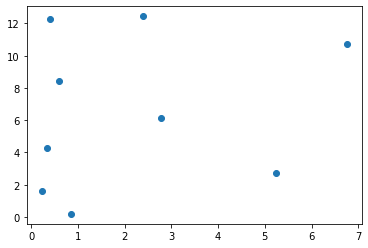

In [16]:
plt.scatter(best_fit[:,0], best_fit[:,1])
plt.show()

In [17]:
from sklearn.cluster import KMeans
# kmeans = KMeans(3)
# means.fit(x)
# identified_clusters = kmeans.fit_predict(x)
# identified_clusters
# KMeans().fit()

In [18]:
OurSOM.cluster(x_vectors, cox_vectors, 9, 10)

<ipython-input-12-6e2c389ddfac>:81: RuntimeWarning: invalid value encountered in true_divide
  cluster_centres = cluster_sums / cluster_count[:,None]


array([[1.339254  , 5.63055062],
       [       nan,        nan],
       [       nan,        nan],
       ...,
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan]])

(563, 2)
(9, 2)


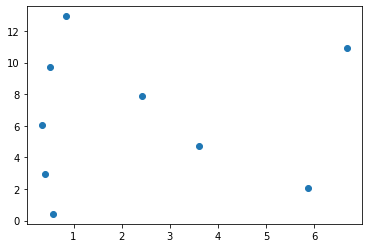

In [19]:
alpha = OurSOM.sk_cluster(x_vectors, cox_vectors, 9, 10)
print(alpha.shape)

plt.scatter(alpha[:,0], alpha[:,1])
plt.show()

In [20]:
x_vectors.shape

(563, 3846)

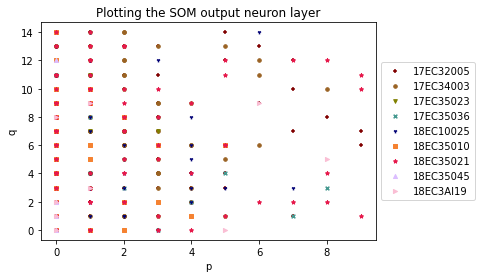

In [21]:
from itertools import *
colors = ['#800000', '#9A6324', '#808000', '#469990', '#000075', '#f58231', '#e6194B', '#dcbeff', '#fabed4']
markers = ['+', 'o', 'v',  'x',  '1',  ',',  '*',  '^',  '>']

p_wins,q_wins =  OurSOM.set_of_winning_neurons(x_vectors, cox_vectors)
c = np.random.randint(1, 9, size=cox_vectors[0].shape)

for tag in range(9):    
    indices = np.where(x_tags==tag)
    plt.scatter(p_wins[indices], q_wins[indices], marker=markers[tag], c=colors[tag], label = '%s' % Roll_nos[tag], s=plt.rcParams['lines.markersize'] * (2.+0.1*tag))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('p')
plt.ylabel('q')
plt.title('Plotting the SOM output neuron layer')
plt.savefig('Clustered.jpg', bbox_inches='tight', dpi=1000)

[3 4 4 3 2 4 1 1 2 3 3 1 3 3 1 3 2 2 2 2 3 1 4 3 3 1 3 2 1 4 4 4 2 2 2 1 4
 4 3 1 1 4 2 3 2]


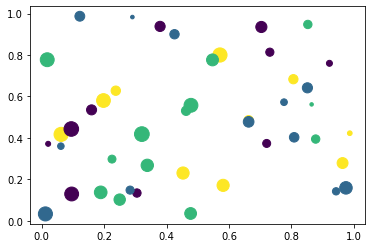

In [22]:
N = 45
x, y = np.random.rand(2, N)
c = np.random.randint(1, 5, size=N)
s = np.random.randint(10, 220, size=N)

fig, ax = plt.subplots()

scatter = ax.scatter(x, y, c=c, s=s)
print(c)
fig.savefig('books_read.png')

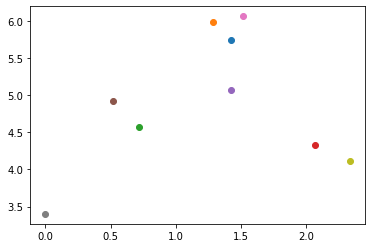

In [23]:
unique_tags = np.unique(x_tags)
num_unique_tags = unique_tags.shape[0]
p =np.zeros(num_unique_tags)
q = np.zeros(num_unique_tags)
for i in range(num_unique_tags):
    indices = np.where(x_tags==unique_tags[i])
    p[i] = np.mean(p_wins[indices])
    q[i] = np.mean(q_wins[indices])
    plt.scatter(p[i],q[i])
plt.show()

In [24]:
np.random.choice(a=10, size=(3,2), replace=False)

array([[8, 9],
       [0, 2],
       [6, 3]])

In [25]:
a = np.array((((1,2,3), (4,5,6), (7,8,9)),((1,2,3), (4,5,6), (7,8,9)),((1,2,3), (4,5,6), (7,8,9))))
a = np.array([1, 2, 3])
b = np.array([10,23,42])
np.concatenate((a[:,None],b[:,None]),axis=1)

array([[ 1, 10],
       [ 2, 23],
       [ 3, 42]])

In [26]:
arr = np.sum( a[:,:,0:2], 2)
v = np.argmax( arr )
p,q = np.shape(arr )
idc = tuple(np.array([v/q, (np.floor(v))%q], dtype=int))
print(arr)
print(idc)
print(arr[idc])

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [ ]:
a[:,:,0:2]

In [ ]:
np.array([5.],dtype=int)

In [ ]:
np.sum(a, axis=0)

In [ ]:
import os
import numpy as np
from keystroke_feature_extractor import extract_keylog_features
from SOM import SOM

# hyperparameters
num_epochs = 100
eta_0 = 1
sigma_0 = 40
t_eta = 50
t_sigma = 50
n = 10

# Find data
Roll_nos = ['17EC32005', '17EC34003', '17EC35023', '17EC35036', '18EC10025', '18EC35010', '18EC35021', '18EC35045', '18EC3AI19']
num_roll_nos = len(Roll_nos)

data_features = []
data_tags = []
unique_features = set([])

# Extract features for each data file
for r in range(num_roll_nos):
    for subdir,dirs,file in os.walk(os.path.join('/home/digvijay-pc/Desktop/MIES/OneDrive_2021-11-08/Continuous Data Rearranged',Roll_nos[r])):
        for directory in dirs:
#             print(subdir,directory)
            features = extract_keylog_features(os.path.join('Continuous Data Rearranged',Roll_nos[r],directory,'Keylog.txt'))
            data_features.append(features)
            data_tags.append(r)
            
            unique_features = unique_features.union(set([ x for (x,y) in features]))

# Split the files into even sizes
data_features_temp = []
data_tags_temp = []

splitting_size = 100

for r in range(len(Roll_nos)):
    indices = np.where(np.array(data_tags)==r)[0]
    features_temp = []
    for i in indices:
        features_temp = features_temp + data_features[i]
    
    j=0
    j_next=0
    while(j_next < len(features_temp)):
        j_next = min(j + splitting_size, len(features_temp))
        data_features_temp.append(features_temp[j:j_next])
        data_tags_temp.append(r)
        j = j_next
    
data_features = data_features_temp
data_tags = data_tags_temp

# Remove features that have high threshold value 
threshold = 1

unique_features_dict = { list(unique_features)[i]: i for i in range(len(unique_features)) }
m = len(unique_features_dict)
D = len(data_features) # number of data points

# Remove proper vectors to represent the data
x_vectors = np.zeros((D,m))
x_tags = np.zeros(D)
cox_vectors = np.zeros((D,m)) # count of x

for d in range(D):
    for (a,a_val) in data_features[d]:
        if(a_val > threshold):
            continue
        a_idx = unique_features_dict[a]
        x_vectors[d,a_idx] = x_vectors[d,a_idx] + a_val
        cox_vectors[d,a_idx] = cox_vectors[d,a_idx] + 1
    cnt_locs = np.where(cox_vectors[d,:]>0)
    x_vectors[d,cnt_locs] = x_vectors[d,cnt_locs] / cox_vectors[d,cnt_locs]
    x_tags[d] = data_tags[d]
    
# Find mean, std and normalise
x_means = np.mean(x_vectors, 0)
x_std = np.std(x_vectors, 0)
cox_total = np.sum(cox_vectors, 0)

std0_locs = np.where(x_std==0)
std_locs = np.where(x_std > 0)

x_vectors[:,std0_locs] = (x_vectors[:,std0_locs] - x_means[std0_locs])
x_vectors[:,std_locs] = (x_vectors[:,std_locs] - x_means[std_locs]) / x_std[std_locs]

# Initialise SOM
OurSOM = SOM(m,n)

# Train
OurSOM.train(x_vectors, cox_vectors, num_epochs, eta_0, sigma_0, t_eta, t_sigma)